라이브러리 없이 MNIST 분류작업 수행

In [2]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=True,download=True, transform=transform)

mnist 데이터 확인하기

torch.Size([1, 28, 28])
torch.Size([28, 28])


<function matplotlib.pyplot.show(close=None, block=None)>

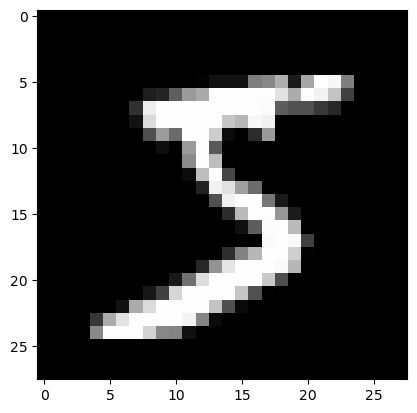

In [3]:
image, label = mnist_data[0]
print(image.shape)
print(image.squeeze().shape)
plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
plt.show

data loader 올리기

< 복기 >
- data loader 안에 들어가야 하는 것 __len__ , __getitem__
- data lodaer 에 넣어서, 배치단위로 꺼낼 수 있게 해야함

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,images,labels,transforms=False):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        """
        여기에서는 실제 이미지와 라벨 쌍을 반환해야함
        :return:
        """
        image = self.images[idx]
        label = self.labels[idx]

        if self.transforms:
            image = self.transforms(image)

        return image,label


8:2로 split 하고 데이터로더 올리기

In [5]:
len(mnist_data)

from torch.utils.data import Subset

train_data = Subset(mnist_data, range(55000))
test_data = Subset(mnist_data, range(55000, 60000))

def seg(data):
    image_data = []
    label_data = []
    for image,label in data:
        image_data.append(image)
        label_data.append(label)

    #print(image_data[0])
    ## 이미지는 픽셀단위로 정보가 있으므로, append 한거 쌓아야함
    image_data = torch.stack(image_data)     # automatically dim=0 기준으로 stack
    print(image_data.shape)

    ## 반면 label은 그냥 1차원 리스트이므로, tensor로 바꾸기
    label_data = torch.tensor(label_data, dtype=torch.long)
    print(label_data.shape)

    return image_data, label_data

train_img, train_lab = seg(train_data)
test_img, test_lab = seg(test_data)

torch.Size([55000, 1, 28, 28])
torch.Size([55000])
torch.Size([5000, 1, 28, 28])
torch.Size([5000])


In [6]:
train_loader = CustomDataset(train_img,train_lab)
test_loader = CustomDataset(test_img,test_lab)

torch.Size([1, 28, 28])
tensor(5)


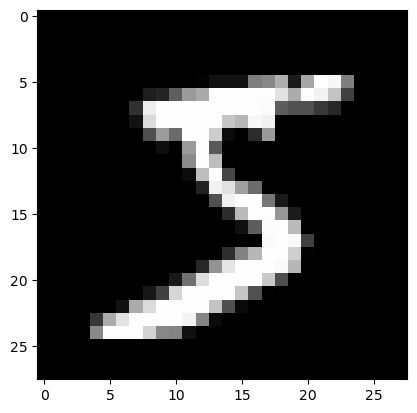

In [7]:
for img,lab in train_loader:
    print(img.shape)
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    print(lab)
    break

TOY EX

In [55]:
# simple gradient descent
# 그래디언트를 도대체 어떻게 구할건데???
# 미분의 정의로 접근. f(x+h)-f(x) / h
    # 이 부분에서 문제점 두가지. 1. 파이썬의 반올림 오차 떄문에 h를 무한히 작은 수로 못보냄 , 2. h가 무한히 작지 않으니까, 실제로 f'(x)가 아니라 f'(x+epsilon) 을 구하는 셈이 되어버림

# 해결책.
    # 1. h는 10^-4
    # 2. f(x+h) - f(x-h) / 2h 로 식을 바꾸기

def gradient(f,x):  ## 여기에 x를 텐서로 제공함
    h = 1e-4
    #print(x)
    x = torch.tensor(x,dtype=torch.float)

    # temp = ((f(x+h)-f(x-h))/(2*h))
    # 이렇게 하면 생기는 문제 -> x가 리스트 형태로 들어가는데, 편미분이니까 잡고 있는 x 말고는 상수 취급 해줘야제
    partial_grad = np.zeros_like(x)

    for idx in range(len(x)):
        temp1 = x.clone()
        temp2 = x.clone()
        temp1[idx] = x[idx] + h
        temp2[idx] = x[idx] - h
        partial_grad[idx] = (f(temp1)-f(temp2))/(2*h)

    return partial_grad

def simple_function(x):
    return x[0]**2 + x[1]**2

print(gradient(simple_function,[3,1]))



[5.993843 2.002716]


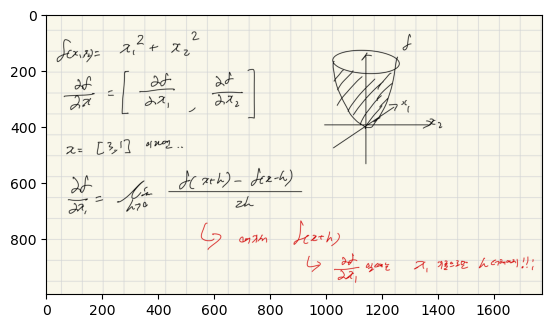

In [52]:
from matplotlib.image import imread
img = imread('../../../../../Downloads/IMG_6964D0C976F6-1.jpeg')

plt.imshow(img)
plt.show()


In [79]:
# gradient update
# 수식은 w -> w - μ ∂f/∂w

def gradient_update(w,steps=100,lr = 1e-2):
    for step in range(steps):
        w -= lr * (gradient(simple_function,w))
    return w

print(gradient_update([1,1],lr=10))
print(gradient_update([1,1],lr=1e-2))
print(gradient_update([1,1],lr=1e-3))

## 점점 0으로 가는 것 확인 가능 !!

[-6674.88710785 -6674.88710785]
[0.13261328 0.13261328]
[0.81853663 0.81853663]


간단한 신경망 구성후, 역전파
- loss : cross-entropy 사용
- weight는 임의로 설정
- 1 layer


In [80]:
def cross_entropy_loss(y,t):    # t : true
    ## cross entropy - KL divergence에서 비롯됨. 정답 레이블의 출력값에만 -log
    delta = 1e-7 # 이거 안더해주면 log 0 나올 수 있음
    return -np.sum(t*np.log(y+delta))

y_pred = np.array([[0.1, 0.2, 0.7], [0.8, 0.1, 0.1]])  # 예측 확률
t_true = np.array([1, 0, 0])  # 정수형 클래스 레이블

cross_entropy_loss(y_pred,t_true)

2.5257275193087634

- 신경망 구성
CNN -> MLP

- < MLP >
    - weight init 부분 직접 설계
    - backpropagation 과정 직접 설계

 < FLOW >
1. 미니배치
2. 기울기 산출
3. 매개변수 갱신

torch.Size([3, 10])


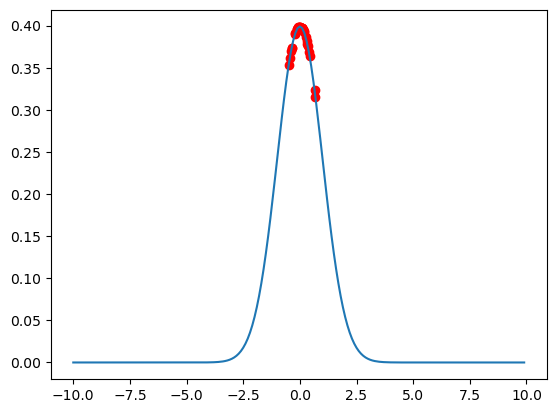

tensor([0.6874, 0.3588, 0.6065, 0.6130, 0.5335, 0.2938, 0.5885, 0.7433, 0.8457,
        0.6501])


In [11]:
import torch.nn as nn
import math


class cnn :
    def __init__(self,kernel,stride,padding):
        self.kernel = kernel
        self.stride = stride
        self.padding = padding

    def forward(self,x):
        x

class classification:
    def __init__(self,kernel,stride,padding,fc1,fc2):


        """
        CNN
        """





        """
        MLP
        """

        self.fc1_in_dim = fc1[0]
        self.fc1_out_dim = fc1[1]
        self.fc1 = torch.empty(self.fc1_out_dim,self.fc1_in_dim)
        self.fc1 = nn.init.xavier_normal_(self.fc1)

        self.fc2_in_dim = fc2[0]
        self.fc2_out_dim = fc2[1]
        self.fc2 = torch.empty(self.fc2_out_dim,self.fc2_in_dim)
        self.fc2 = nn.init.xavier_normal_(self.fc2)


        """
        weight 시각화
        """
        print(self.weight.shape) #-> out_dim , in_dim
        def normal_distribution(x):
            return (1/(math.sqrt(2*math.pi))*1)*torch.exp(-0.5*(x-0)**2/1**2)

        x = np.arange(-10,10,0.1)
        x = torch.tensor(x)
        plt.plot(x,normal_distribution(x))
        plt.scatter(self.weight.flatten(),normal_distribution(self.weight.flatten()),color="red", label="Sampled Weights")
        plt.show()

    def sigmoid(self,x):
        return 1/(1+torch.exp(-x))


    def forward(self,x):
        x = torch.matmul(x,self.weight)
        x = self.sigmoid(x)
        x = torch.matmul
        return x


ex = torch.randn(3)
print(hola.forward(ex))



